In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data_avg = pd.read_csv("/content/drive/MyDrive/data_avg_4.csv")

In [ ]:
data_avg

,Pixel_ID,Timestep,Rainfall,Temperature,Date,avg_NDVI,avg_DEM
0,1,1,6.4,16.8,2018-10-17,0.459239,225.793652
1,1,2,3.2,17.6,2018-10-22,0.340360,225.793652
2,1,3,0.4,16.6,2018-10-27,0.337288,225.793652
3,1,4,5.0,10.0,2018-11-01,0.479742,225.793652
4,1,5,4.0,13.2,2018-11-06,0.256560,225.793652
...,...,...,...,...,...,...,...
240805,23667,26,0.6,14.0,2019-09-16,0.694676,25.636216
240806,23667,27,0.2,9.6,2019-09-21,0.702523,25.636216
240807,23667,28,0.0,9.2,2019-09-26,0.689789,25.636216
240808,23667,29,2.4,10.6,2019-10-01,0.710349,25.636216


In [ ]:
data_avg.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pixel_ID,240810.0,11125.639591,6950.107372,1.000000,5279.000000,8790.000000,16874.000000,23667.000000
Timestep,240810.0,15.500000,8.655459,1.000000,8.000000,15.500000,23.000000,30.000000
Rainfall,240810.0,1.016927,2.003039,0.000000,0.000000,0.000000,1.200000,61.000000
Temperature,240810.0,18.345869,6.256303,-10.200000,13.200000,19.200000,23.400000,33.000000
avg_NDVI,240810.0,0.495967,0.197725,0.000000,0.333080,0.497055,0.651315,0.999615
avg_DEM,240810.0,381.717972,294.886380,-1.249939,158.028263,298.117576,525.480979,1846.124875


# 1. Split and normalize the data

In [ ]:
#Split the data in 70% training, 20% validation and 10% testing
from sklearn.model_selection import train_test_split

pixel_ids = data_avg['Pixel_ID'].unique()

# Randomly shuffle the pixel_ids
np.random.shuffle(pixel_ids)

split_idx_1 = int(0.7 * len(pixel_ids))
split_idx_2 = int(0.9 * len(pixel_ids))

train_pixel_ids = pixel_ids[:split_idx_1]
val_pixel_ids = pixel_ids[split_idx_1:split_idx_2]
test_pixel_ids = pixel_ids[split_idx_2:]

train = data_avg.loc[data_avg['Pixel_ID'].isin(train_pixel_ids)]
val = data_avg.loc[data_avg['Pixel_ID'].isin(val_pixel_ids)]
test = data_avg.loc[data_avg['Pixel_ID'].isin(test_pixel_ids)]

In [ ]:
# Normalization use minmaxscaler

from sklearn.preprocessing import MinMaxScaler

# Create the Scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform it
ndvi_dem_rain_temp_train = train[['avg_NDVI','avg_DEM','Rainfall', 'Temperature']].copy()
ndvi_dem_rain_temp_train_scaled = scaler.fit_transform(ndvi_dem_rain_temp_train)
train_scaled_avg = pd.concat([train, pd.DataFrame(ndvi_dem_rain_temp_train_scaled, columns=['NDVI_scaled', 'DEM_scaled', 'Rainfall_scaled', 'Temperature_scaled'], index=ndvi_dem_rain_temp_train.index)], axis=1)

# Transform the validation data using the same scaler
ndvi_dem_rain_temp_val = val[['avg_NDVI','avg_DEM', 'Rainfall', 'Temperature']].copy()
ndvi_dem_rain_temp_val_scaled = scaler.transform(ndvi_dem_rain_temp_val)
val_scaled_avg = pd.concat([val, pd.DataFrame(ndvi_dem_rain_temp_val_scaled, columns=['NDVI_scaled', 'DEM_scaled','Rainfall_scaled', 'Temperature_scaled'], index=ndvi_dem_rain_temp_val.index)], axis=1)

# Transform the testing data using the same scaler
ndvi_dem_rain_temp_test = test[['avg_NDVI','avg_DEM', 'Rainfall', 'Temperature']].copy()
ndvi_dem_rain_temp_test_scaled = scaler.transform(ndvi_dem_rain_temp_test)
test_scaled_avg = pd.concat([test, pd.DataFrame(ndvi_dem_rain_temp_test_scaled, columns=['NDVI_scaled','DEM_scaled', 'Rainfall_scaled', 'Temperature_scaled'], index=ndvi_dem_rain_temp_test.index)], axis=1)


In [ ]:
train_scaled_avg

In [ ]:
train_scaled_avg.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pixel_ID,168540.0,11030.439480,6903.883096,8.000000,5246.000000,8767.500000,16751.000000,23584.000000
Timestep,168540.0,15.500000,8.655467,1.000000,8.000000,15.500000,23.000000,30.000000
Rainfall,168540.0,1.022940,2.030464,0.000000,0.000000,0.000000,1.200000,61.000000
Temperature,168540.0,18.306588,6.254347,-10.200000,13.200000,19.200000,23.400000,33.000000
avg_NDVI,168540.0,0.495490,0.196815,0.000000,0.333829,0.497109,0.648922,0.999604
avg_DEM,168540.0,383.521352,297.440625,-1.249939,157.863994,298.944473,527.569682,1846.124875
NDVI_scaled,168540.0,0.495686,0.196893,0.000000,0.333962,0.497306,0.649179,1.000000
DEM_scaled,168540.0,0.208280,0.161007,0.000000,0.086130,0.162498,0.286255,1.000000
Rainfall_scaled,168540.0,0.016770,0.033286,0.000000,0.000000,0.000000,0.019672,1.000000
Temperature_scaled,168540.0,0.659875,0.144777,0.000000,0.541667,0.680556,0.777778,1.000000


In [ ]:
# Check for NaN values in the scaled input features
has_nan = train_scaled_avg.isna().any().any()
print("NaN values in the scaled input features:", has_nan)

NaN values in the scaled input features: False


# 2. Build data structure for train the model

In [ ]:
# Import necessary libraries

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation, Flatten
from tensorflow.keras.layers import LayerNormalization, BatchNormalization, MultiHeadAttention, TimeDistributed
from tensorflow.keras.layers import Conv1D, Conv2D, ConvLSTM2D, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.layers import GlobalAveragePooling1D, AveragePooling1D, GlobalMaxPooling1D

from tensorflow.keras.regularizers import l1,l2
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import backend as K
import joblib
from keras.models import load_model
import time
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import layers, Model


In [ ]:
# Select input and output variables
input_vars = ['NDVI_scaled','DEM_scaled', 'Rainfall_scaled', 'Temperature_scaled']
output_var = 'NDVI_scaled'

# Define window size for input sequences
window_size = 20

# Create sequences of input and output for training data
X_train_avg = []
y_train_avg = []
for pixel_id in train_scaled_avg['Pixel_ID'].unique():
    pixel_data = train_scaled_avg[train_scaled_avg['Pixel_ID'] == pixel_id].reset_index(drop=True)
    for i in range(window_size, pixel_data.shape[0]):
        X_train_avg.append(pixel_data.loc[i-window_size:i-1, input_vars].values)
        y_train_avg.append(pixel_data.loc[i, output_var])

# Create sequences of input and output for validation data
X_val_avg = []
y_val_avg = []
for pixel_id in val_scaled_avg['Pixel_ID'].unique():
    pixel_data = val_scaled_avg[val_scaled_avg['Pixel_ID'] == pixel_id].reset_index(drop=True)
    for i in range(window_size, pixel_data.shape[0]):
        X_val_avg.append(pixel_data.loc[i-window_size:i-1, input_vars].values)
        y_val_avg.append(pixel_data.loc[i, output_var])

# Create sequences of input and output for testing data
X_test_avg = []
y_test_avg = []
for pixel_id in test_scaled_avg['Pixel_ID'].unique():
    pixel_data = test_scaled_avg[test_scaled_avg['Pixel_ID'] == pixel_id].reset_index(drop=True)
    for i in range(window_size, pixel_data.shape[0]):
        X_test_avg.append(pixel_data.loc[i-window_size:i-1, input_vars].values)
        y_test_avg.append(pixel_data.loc[i, output_var])

# Convert X and y to numpy arrays
X_train_avg = np.array(X_train_avg)
y_train_avg = np.array(y_train_avg)
X_val_avg = np.array(X_val_avg)
y_val_avg = np.array(y_val_avg)
X_test_avg = np.array(X_test_avg)
y_test_avg = np.array(y_test_avg)

In [ ]:
X_test_avg_reshaped = pd.DataFrame(X_test_avg.reshape(X_test_avg.shape[0], -1))
X_test_avg_reshaped.shape

(8030, 80)

## 2.1 Random forest model

In [ ]:
# Train the Random Forest model with increased n_estimators and max_depth
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
# Start recording training time
start_time_rf = time.time()

In [ ]:
rf_model.fit(X_train_avg.reshape((X_train_avg.shape[0], -1)), y_train_avg)

RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)

In [ ]:
# Calculate the training time
training_time_rf = time.time() - start_time_rf
print("Training time: ", training_time_rf, "seconds")

Training time:  351.48262667655945 seconds


In [ ]:
# Evaluate the model on the test set
rf_test_flat = X_test_avg.reshape(X_test_avg.shape[0], -1)

rf_mse = mean_squared_error(y_test_avg, rf_model.predict(rf_test_flat))
print("Random forest MSE:", rf_mse)

Random forest MSE: 0.0033802484932523354


In [ ]:
# Save the model
joblib.dump(rf_model, "/content/drive/MyDrive/Saved_models/rf_model_avg_4.pkl")

['/content/drive/MyDrive/Saved_models/rf_model_avg_4.pkl']

In [ ]:
# Load rf model
rf_model = joblib.load("/content/drive/MyDrive/Saved_models/rf_model_avg_4.pkl")

In [ ]:
# Predict the NDVI values using the Random Forest model
rf_pred_test = rf_model.predict(X_test_avg.reshape((X_test_avg.shape[0], -1)))

# Inverse transform the predicted NDVI values
#inverse_rf_pred_test = scaler.inverse_transform(np.hstack([rf_pred_test.reshape(-1, 1), np.zeros((rf_pred_test.shape[0], 2))]))[:, 0]

rf_pred_test.shape

(8030,)

In [ ]:
# Inverse transform the predicted NDVI values
# rf_inverse_y_pred_test = scaler.inverse_transform(np.hstack([rf_pred_test.reshape(-1, 1), np.zeros((rf_pred_test.shape[0], 2))]))[:, 0]

[0.75378738 0.74642369 0.73363027 ... 0.32096486 0.31442708 0.32181357]


,count,mean,std,min,25%,50%,75%,max
0,20520.0,0.560223,0.175878,-0.752662,0.440023,0.571023,0.700453,0.886475


## 2.2 LSTM model

In [ ]:
from keras.regularizers import L1L2
learning_rate = 0.0001
# Define the LSTM model architecture
lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape=(window_size, len(input_vars)), activation='tanh', kernel_regularizer=L1L2(l1=0.01, l2=0.01)))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(1))

# Compile the model with the desired learning rate
optimizer = Adam(learning_rate=learning_rate)
lstm_model.compile(loss="MSE", optimizer=optimizer)
# Set up early stopping callback with increased patience
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Start recording training time
start_time_lstm = time.time()

In [ ]:
# Train the model
lstm_history = lstm_model.fit(
    X_train_avg, y_train_avg,
    epochs=200,
    batch_size=32,
    validation_data=(X_val_avg, y_val_avg),
    callbacks=[early_stop]
)

Epoch 1/200
1756/1756 [==============================] - 10s 5ms/step - loss: 0.2821 - val_loss: 0.0133
Epoch 2/200
1756/1756 [==============================] - 8s 4ms/step - loss: 0.0109 - val_loss: 0.0093
Epoch 3/200
1756/1756 [==============================] - 8s 4ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 4/200
1756/1756 [==============================] - 8s 4ms/step - loss: 0.0077 - val_loss: 0.0071
Epoch 5/200
1756/1756 [==============================] - 8s 4ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 6/200
1756/1756 [==============================] - 8s 4ms/step - loss: 0.0066 - val_loss: 0.0064
Epoch 7/200
1756/1756 [==============================] - 8s 4ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 8/200
1756/1756 [==============================] - 8s 4ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 9/200
1756/1756 [==============================] - 8s 4ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 10/200
1756/1756 [==============================] - 8s 4ms/step - 

In [ ]:
# Calculate the training time
training_time_lstm = time.time() - start_time_lstm
print("Training time: ", training_time_lstm, "seconds")

Training time:  1009.0182795524597 seconds


In [ ]:
# Evaluate the model on the test set
lstm_mse = mean_squared_error(y_test_avg, lstm_model.predict(X_test_avg))
print("LSTM MSE:", lstm_mse)

251/251 [==============================] - 1s 2ms/step
LSTM MSE: 0.003642509145283839


In [ ]:
lstm_model.save("/content/drive/MyDrive/Saved_models/lstm_model_avg_4")

In [ ]:
# Load lstm model
lstm_model = load_model("/content/drive/MyDrive/Saved_models/lstm_model_avg_4")

In [ ]:
# Predict the NDVI values
lstm_pred_test = lstm_model.predict(X_test_avg)

# Inverse transform the predicted NDVI values
# lstm_inverse_y_pred_test = scaler.inverse_transform(np.hstack([lstm_pred_test.reshape(-1, 1), np.zeros((lstm_pred_test.shape[0], 2))]))[:, 0]

lstm_pred_test.shape

251/251 [==============================] - 4s 2ms/step


(8030, 1)

In [ ]:
# Plot training and validation loss for LSTM
plt.figure(figsize=(6, 3))
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
print("X_train shape:", np.shape(X_train_avg))
print("X_val shape:", np.shape(X_val_avg))
print("X_test shape:", np.shape(X_test_avg))
print("y_train shape:", np.shape(y_train_avg))
print("y_val shape:", np.shape(y_val_avg))
print("y_test shape:", np.shape(y_test_avg))

X_train shape: (56180, 20, 4)
X_val shape: (16060, 20, 4)
X_test shape: (8030, 20, 4)
y_train shape: (56180,)
y_val shape: (16060,)
y_test shape: (8030,)


# 3. Compare the model performance

In [ ]:
# Load models
rf_model = joblib.load("/content/drive/MyDrive/Saved_models/rf_model_avg_4.pkl")

In [ ]:
# Load models
lstm_model = load_model("/content/drive/MyDrive/Saved_models/lstm_model_avg_4")


In [ ]:
# predicted NDVI values for rf, LSTM,convLSTM,transformer model
#test

# Predict the NDVI values using the Random Forest model
rf_pred_test = rf_model.predict(X_test_avg.reshape((X_test_avg.shape[0], -1)))
lstm_pred_test = lstm_model.predict(X_test_avg)

#val
rf_pred_val = rf_model.predict(X_val_avg.reshape((X_val_avg.shape[0], -1)))
lstm_pred_val = lstm_model.predict(X_val_avg)


502/502 [==============================] - 1s 2ms/step


In [ ]:
# Compare the model performance by scatter plot of predicted and expected NDVI

# Inverse transform the true NDVI values for the test set
inverse_y_test_avg = scaler.inverse_transform(np.hstack([y_test_avg.reshape(-1, 1), np.zeros((y_test_avg.shape[0], 3))]))[:, 0]
# Inverse transform the true NDVI values for the validation set
inverse_y_val_avg = scaler.inverse_transform(np.hstack([y_val_avg.reshape(-1, 1), np.zeros((y_val_avg.shape[0], 3))]))[:, 0]

# Inverse transform the predicted NDVI test values for 4 models
rf_inverse_y_pred_test = scaler.inverse_transform(np.hstack([rf_pred_test.reshape(-1, 1), np.zeros((rf_pred_test.shape[0], 3))]))[:, 0]
lstm_inverse_y_pred_test = scaler.inverse_transform(np.hstack([lstm_pred_test, np.zeros((lstm_pred_test.shape[0], 3))]))[:, 0]

# Inverse transform the predicted NDVI validation values for 4 models
rf_inverse_y_pred_val = scaler.inverse_transform(np.hstack([rf_pred_val.reshape(-1, 1), np.zeros((rf_pred_val.shape[0], 3))]))[:, 0]
lstm_inverse_y_pred_val = scaler.inverse_transform(np.hstack([lstm_pred_val, np.zeros((lstm_pred_val.shape[0], 3))]))[:, 0]


# Calculate MSE for each model on testing set
mse_rf_val = mean_squared_error(inverse_y_val_avg, rf_inverse_y_pred_val)
mse_lstm_val = mean_squared_error(inverse_y_val_avg, lstm_inverse_y_pred_val)

# Calculate MSE for each model on testing set
mse_rf_test = mean_squared_error(inverse_y_test_avg, rf_inverse_y_pred_test)
mse_lstm_test = mean_squared_error(inverse_y_test_avg, lstm_inverse_y_pred_test)

# Calculate R2 scores for the test set
r2_rf_test = r2_score(inverse_y_test_avg, rf_inverse_y_pred_test)
r2_lstm_test = r2_score(inverse_y_test_avg, lstm_inverse_y_pred_test)

# Calculate RMSE scores for the test set
rmse_rf_test = np.sqrt(mean_squared_error(inverse_y_test_avg, rf_inverse_y_pred_test))
rmse_lstm_test = np.sqrt(mean_squared_error(inverse_y_test_avg, lstm_inverse_y_pred_test))


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE for each model on testing set
mae_rf_test = mean_absolute_error(inverse_y_test_avg, rf_inverse_y_pred_test)
mae_lstm_test = mean_absolute_error(inverse_y_test_avg, lstm_inverse_y_pred_test)


In [ ]:
mae_rf_test

## 3.1 Visualization

**- Scatter plot**

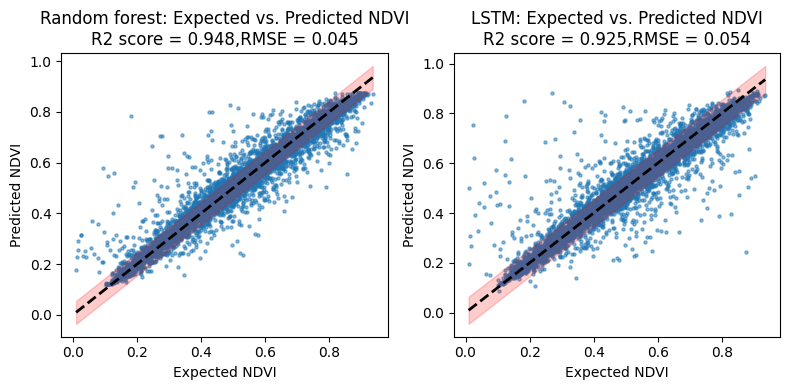

In [ ]:
# Create a 2x2 grid of subplots for the 4 different models
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Set titles and labels
titles = ['Random forest', 'LSTM']
predictions = [rf_inverse_y_pred_test, lstm_inverse_y_pred_test]
r2_scores = [r2_rf_test, r2_lstm_test]
rmse_scores = [rmse_rf_test, rmse_lstm_test]
for idx, ax in enumerate(axes.flatten()):
    ax.scatter(inverse_y_test_avg, predictions[idx], s=5, alpha=0.5)

    # One-to-one line
    min_val = np.min(inverse_y_test_avg)
    max_val = np.max(inverse_y_test_avg)
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

    # Deviation line
    deviation = np.std(inverse_y_test_avg - predictions[idx])
    ax.fill_between(np.sort(inverse_y_test_avg.flatten()), np.sort(inverse_y_test_avg.flatten()) - deviation, np.sort(inverse_y_test_avg.flatten()) + deviation, alpha=0.2, color='r')

    ax.set_xlabel('Expected NDVI')
    ax.set_ylabel('Predicted NDVI')
    ax.set_title(f'{titles[idx]}: Expected vs. Predicted NDVI\nR2 score = {r2_scores[idx]:.3f},RMSE = {rmse_scores[idx]:.3f}')

plt.tight_layout()
plt.show()

**- MSE histogram**

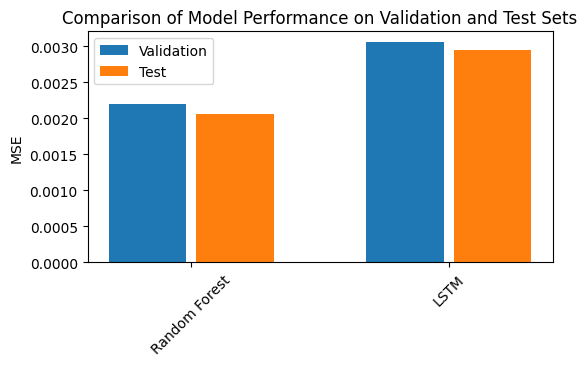

In [ ]:
# Compare the Mean Squared Error (MSE) for models

# Plot bar chart
plt.figure(figsize=(6, 3))
x = np.arange(2)
width = 0.3


plt.bar(x - 0.17, [mse_rf_val, mse_lstm_val], width, label='Validation')
plt.bar(x + 0.17, [mse_rf_test, mse_lstm_test], width, label='Test')
plt.xticks(ticks=x, labels=['Random Forest', 'LSTM'],
           rotation=45)
plt.ylabel('MSE')
plt.title('Comparison of Model Performance on Validation and Test Sets')
_ = plt.legend()
plt.show()



**- Residual plot**

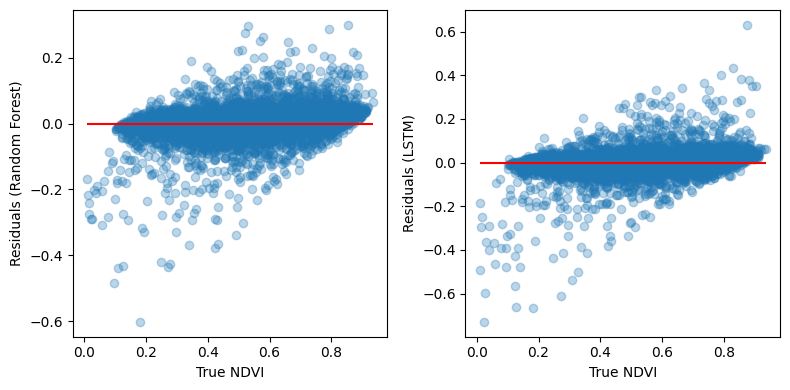

In [ ]:
#Comapre the residual

residuals_rf = inverse_y_test_avg - rf_inverse_y_pred_test
residuals_lstm = inverse_y_test_avg - lstm_inverse_y_pred_test

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Scatter plot for Random Forest residuals
ax1.scatter(inverse_y_test_avg, residuals_rf, alpha=0.3)
ax1.set_xlabel('True NDVI')
ax1.set_ylabel('Residuals (Random Forest)')
ax1.hlines(0, min(inverse_y_test_avg), max(inverse_y_test_avg), color='red')  # Line at zero

# Scatter plot for LSTM residuals
ax2.scatter(inverse_y_test_avg, residuals_lstm, alpha=0.3)
ax2.set_xlabel('True NDVI')
ax2.set_ylabel('Residuals (LSTM)')
ax2.hlines(0, min(inverse_y_test_avg), max(inverse_y_test_avg), color='red')  # Line at zero

plt.tight_layout()
plt.show()


**- NDVI in timeseries**

In [ ]:
# Convert numpy arrays to dataframes
inverse_y_test_avg_df = pd.DataFrame(inverse_y_test_avg, columns=['True NDVI'])
rf_inverse_y_pred_test_df = pd.DataFrame(rf_inverse_y_pred_test, columns=['Predicted NDVI (Random Forest)'])
lstm_inverse_y_pred_test_df = pd.DataFrame(lstm_inverse_y_pred_test, columns=['Predicted NDVI (LSTM)'])

# Merge dataframes into a single dataframe
merged_df = pd.concat([inverse_y_test_avg_df, rf_inverse_y_pred_test_df, lstm_inverse_y_pred_test_df], axis=1)


NameError: ignored

In [ ]:
merged_df

In [ ]:
import matplotlib.pyplot as plt

# Select the first 90 rows
df_subset = merged_df.iloc[:90]

# Create a figure with six subplots
fig, axs = plt.subplots(3, 2, figsize=(16, 8))

# Loop over each pixel
for i in range(3):
    start = i * 30
    end = (i+1) * 30

    # Plot True NDVI and RF NDVI in the first subplot of each row
    axs[i, 0].plot(df_subset.index[start+1:end], df_subset['True NDVI'].values[start+1:end], label='True NDVI')
    axs[i, 0].plot(df_subset.index[start:end-1], df_subset['Predicted NDVI (Random Forest)'].values[start:end-1], label='RF Predicted NDVI')
    axs[i, 0].set_ylabel('NDVI')
    axs[i, 0].legend()

    # Plot True NDVI and LSTM NDVI in the second subplot of each row
    axs[i, 1].plot(df_subset.index[start+1:end], df_subset['True NDVI'].values[start+1:end], label='True NDVI')
    axs[i, 1].plot(df_subset.index[start:end-1], df_subset['Predicted NDVI (LSTM)'].values[start:end-1], label='LSTM Predicted NDVI')
    axs[i, 1].set_ylabel('NDVI')
    axs[i, 1].legend()

# Add labels to the last row
axs[2, 0].set_xlabel('Time')
axs[2, 1].set_xlabel('Time')

# Add title to the figure
fig.suptitle('Comparison of True NDVI with RF and LSTM Predicted NDVI')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


NameError: ignored

# 4. View the single and multiple steps prediction performance

## 4.1 Single prediction step

1/1 [==============================] - 0s 18ms/step


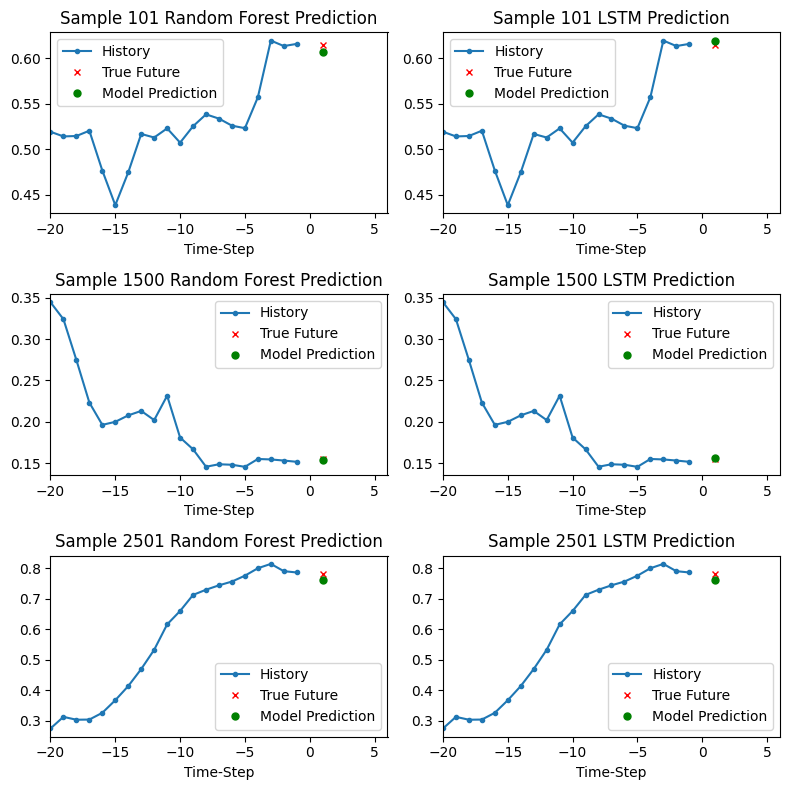

In [ ]:
# single step prediction for all models in one graph

def show_plot(plot_data, title, ax):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    future = 1

    ax.set_title(title)
    for i, val in enumerate(plot_data):
        if i:
            ax.plot(future, plot_data[i], marker[i], markersize=5, label=labels[i])
        else:
            ax.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    ax.legend()
    ax.set_xlim([time_steps[0], (future + 2) * 2])
    ax.set_xlabel("Time-Step")

# Prepare data for the plot
n = 3  # number of samples to visualize
specified_indices = [100, 1499, 2500]  # samples 1, 1000 and 3000

fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(8, 8))  # adjust figsize as needed

for i, idx in enumerate(specified_indices):
    x_sample = X_test_avg[idx]
    y_sample = y_test_avg[idx]
    history_ndvi = x_sample[:, 0]  # Select only NDVI_scaled from input_vars
    true_future = y_sample

    # Random Forest
    y_pred_rf = rf_model.predict(x_sample.reshape(1, -1))[0]
    ax = axes[i, 0]
    show_plot([history_ndvi, true_future, y_pred_rf], f"Sample {idx + 1} Random Forest Prediction", ax)

    # LSTM
    y_pred_lstm = lstm_model.predict(x_sample[np.newaxis, :, :])[0]
    ax = axes[i, 1]
    show_plot([history_ndvi, true_future, y_pred_lstm], f"Sample {idx + 1} LSTM Prediction", ax)


plt.tight_layout()
plt.show()

## 4.2 Multiple prediction steps

### predict 5 timesteps in the future

In [ ]:
from sklearn.metrics import r2_score

# Specify indices to visualize
specified_indices = [100, 1499, 2500]

# Create empty lists to store the predicted values
predicted_rf_values = []
predicted_lstm_values = []
true_values = []

# Number of future steps
n_steps = 5

# Calculate predictions and store values
for i, idx in enumerate(specified_indices):
    preds_rf, preds_lstm = [], []
    x_sample_rf = X_test_avg[idx].reshape(1, -1)
    x_sample_lstm = X_test_avg[idx][np.newaxis, :, :]

    # Predict future values
    for _ in range(n_steps):
        y_pred_rf = rf_model.predict(x_sample_rf)
        y_pred_lstm = lstm_model.predict(x_sample_lstm)[0]

        # Add the prediction to the respective lists
        preds_rf.append(y_pred_rf[0])
        preds_lstm.append(y_pred_lstm[0])

        # Update x_sample to include the new prediction and exclude the first value
        x_sample_rf = np.roll(x_sample_rf, -1)
        x_sample_rf[-1] = y_pred_rf

        x_sample_lstm = np.roll(x_sample_lstm, -1, axis=1)
        x_sample_lstm[0, -1, 0] = y_pred_lstm  # Update the last value with the new prediction

    # Append the predicted values and true values at the 5th timestep to the lists
    predicted_rf_values.append(preds_rf[-1])  # Index -1 represents the 5th timestep
    predicted_lstm_values.append(preds_lstm[-1])
    true_values.append(y_test_avg[idx + n_steps - 1])  # Index idx + n_steps - 1 represents the 5th timestep

# Calculate R2 scores
r2_rf = r2_score(true_values, predicted_rf_values)
r2_lstm = r2_score(true_values, predicted_lstm_values)

# Print the R2 scores
print("R2 score (RF):", r2_rf)
print("R2 score (LSTM):", r2_lstm)


1/1 [==============================] - 0s 23ms/step
R2 score (RF): -0.5781722591996552
R2 score (LSTM): 0.9149398623148995


In [ ]:
from sklearn.metrics import r2_score

# Specify indices to visualize
specified_indices = [100, 1999, 2500]

# Create empty lists to store the predicted values
predicted_rf_values = []
predicted_lstm_values = []
true_values = []

# Number of future steps
n_steps = 5

# Calculate predictions and store values
for i, idx in enumerate(specified_indices):
    preds_rf, preds_lstm = [], []
    x_sample_rf = X_test_avg[idx].reshape(1, -1)
    x_sample_lstm = X_test_avg[idx][np.newaxis, :, :]

    # Predict future values
    for _ in range(n_steps):
        y_pred_rf = rf_model.predict(x_sample_rf)
        y_pred_lstm = lstm_model.predict(x_sample_lstm)[0]

        # Add the prediction to the respective lists
        preds_rf.append(y_pred_rf[0])
        preds_lstm.append(y_pred_lstm[0])

        # Update x_sample to include the new prediction and exclude the first value
        x_sample_rf = np.roll(x_sample_rf, -1)
        x_sample_rf[-1] = y_pred_rf

        x_sample_lstm = np.roll(x_sample_lstm, -1, axis=1)
        x_sample_lstm[0, -1, 0] = y_pred_lstm  # Update the last value with the new prediction

    # Select the next `n_steps` true future values for plotting
    true_future = y_test_avg[idx: idx + n_steps]

    # Append the predictions and true values to the lists
    predicted_rf_values.extend(preds_rf)
    predicted_lstm_values.extend(preds_lstm)
    true_values.extend(true_future)

# Calculate R2 scores
r2_rf = r2_score(true_values[:1000], predicted_rf_values[:1000])
r2_lstm = r2_score(true_values[:1000], predicted_lstm_values[:1000])

# Print the R2 scores
print("R2 score (RF):", r2_rf)
print("R2 score (LSTM):", r2_lstm)


1/1 [==============================] - 0s 17ms/step
R2 score (RF): 0.4898400089515371
R2 score (LSTM): 0.9293574633088332


1/1 [==============================] - 0s 17ms/step


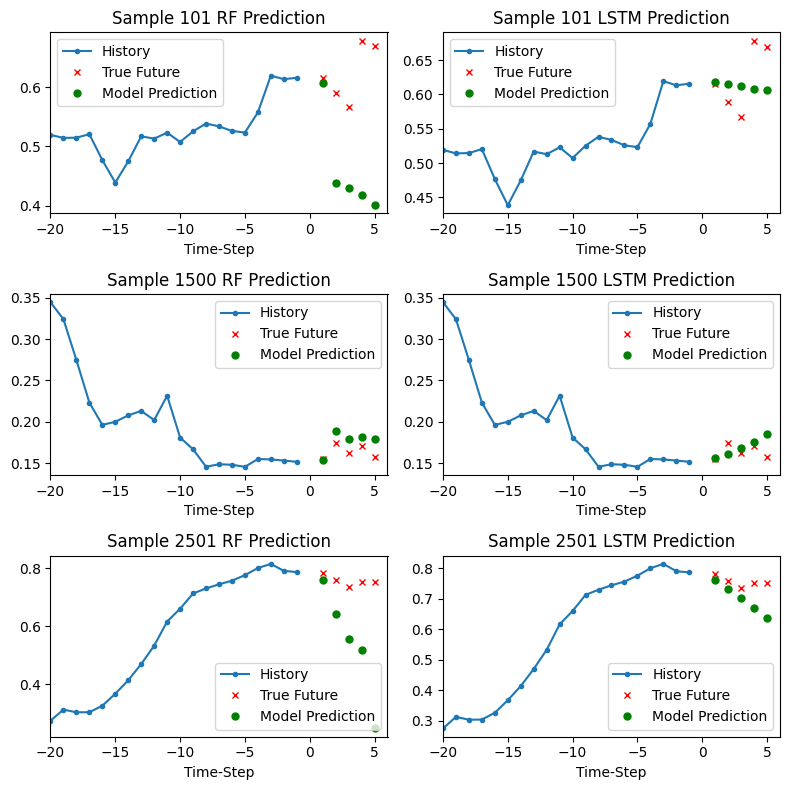

In [ ]:

# The modified show_plot function
def show_plot(plot_data, delta, title, ax):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-plot_data[0].shape[0], 0))
    future = np.arange(delta, delta + len(plot_data[2]))

    ax.set_title(title)
    for i, val in enumerate(plot_data):
        if i == 0:  # History
            ax.plot(time_steps, val.flatten(), marker[i], label=labels[i])
        elif i == 1:  # True Future
            ax.plot(future[:len(val)], val, marker[i], markersize=5, label=labels[i])
        elif i == 2:  # Model Prediction
            ax.plot(future, val, marker[i], markersize=5, label=labels[i])
    ax.legend()
    ax.set_xlim([time_steps[0], delta + n_steps])
    ax.set_xlabel("Time-Step")

# specify indices to visualize
specified_indices = [100, 1499, 2500]

# Create figure and axes
fig, axes = plt.subplots(nrows=len(specified_indices), ncols=2, figsize=(8, 8))

# Number of future steps
n_steps = 5

for i, idx in enumerate(specified_indices):
    preds_rf, preds_lstm = [], []
    x_sample_rf = X_test_avg[idx].reshape(1, -1)
    x_sample_lstm = X_test_avg[idx][np.newaxis, :, :]

    # Predict future values
    for _ in range(n_steps):
        y_pred_rf = rf_model.predict(x_sample_rf)
        y_pred_lstm = lstm_model.predict(x_sample_lstm)[0]

        # Add the prediction to the list
        preds_rf.append(y_pred_rf[0])
        preds_lstm.append(y_pred_lstm[0])

        # Update x_sample to include the new prediction and exclude the first value
        x_sample_rf = np.roll(x_sample_rf, -1)
        x_sample_rf[-1] = y_pred_rf

        x_sample_lstm = np.roll(x_sample_lstm, -1, axis=1)
        x_sample_lstm[0, -1, 0] = y_pred_lstm  # Update the last value with the new prediction

    # Select the next `n_steps` true future values for plotting
    # Create subplots
    ax1, ax2 = axes[i, 0], axes[i, 1]

    # Select the next `n_steps` true future values for plotting
    true_future = y_test_avg[idx: idx+n_steps]

    # Plot history, true future, and model predictions
    history_ndvi = X_test_avg[idx][:, 0]  # Select only NDVI_scaled from input_vars
    show_plot([history_ndvi, true_future, preds_rf], 1, f"Sample {idx + 1} RF Prediction", ax1)
    show_plot([history_ndvi, true_future, preds_lstm], 1, f"Sample {idx + 1} LSTM Prediction", ax2)
plt.tight_layout()
plt.show()


### predict 10 timesteps in the future

1/1 [==============================] - 0s 21ms/step


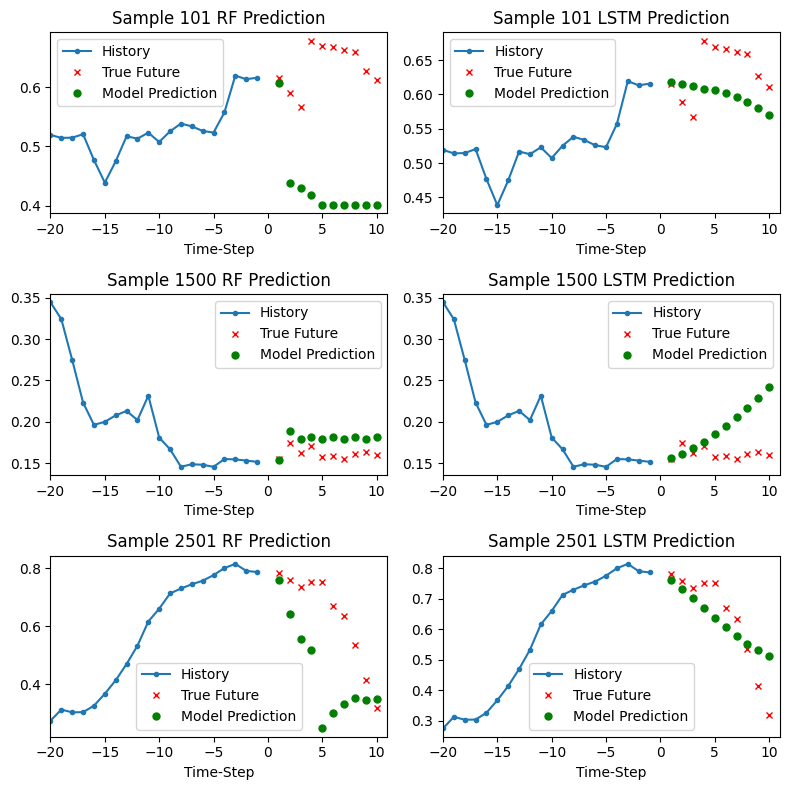

In [ ]:

# The modified show_plot function
def show_plot(plot_data, delta, title, ax):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-plot_data[0].shape[0], 0))
    future = np.arange(delta, delta + len(plot_data[2]))

    ax.set_title(title)
    for i, val in enumerate(plot_data):
        if i == 0:  # History
            ax.plot(time_steps, val.flatten(), marker[i], label=labels[i])
        elif i == 1:  # True Future
            ax.plot(future[:len(val)], val, marker[i], markersize=5, label=labels[i])
        elif i == 2:  # Model Prediction
            ax.plot(future, val, marker[i], markersize=5, label=labels[i])
    ax.legend()
    ax.set_xlim([time_steps[0], delta + n_steps])
    ax.set_xlabel("Time-Step")

# specify indices to visualize
specified_indices = [100, 1499, 2500]

# Create figure and axes
fig, axes = plt.subplots(nrows=len(specified_indices), ncols=2, figsize=(8, 8))

# Number of future steps
n_steps = 10

for i, idx in enumerate(specified_indices):
    preds_rf, preds_lstm = [], []
    x_sample_rf = X_test_avg[idx].reshape(1, -1)
    x_sample_lstm = X_test_avg[idx][np.newaxis, :, :]

    # Predict future values
    for _ in range(n_steps):
        y_pred_rf = rf_model.predict(x_sample_rf)
        y_pred_lstm = lstm_model.predict(x_sample_lstm)[0]

        # Add the prediction to the list
        preds_rf.append(y_pred_rf[0])
        preds_lstm.append(y_pred_lstm[0])

        # Update x_sample to include the new prediction and exclude the first value
        x_sample_rf = np.roll(x_sample_rf, -1)
        x_sample_rf[-1] = y_pred_rf

        x_sample_lstm = np.roll(x_sample_lstm, -1, axis=1)
        x_sample_lstm[0, -1, 0] = y_pred_lstm  # Update the last value with the new prediction

    # Create subplots
    ax1, ax2 = axes[i, 0], axes[i, 1]

    # Select the next `n_steps` true future values for plotting
    true_future = y_test_avg[idx: idx+n_steps]

    # Plot history, true future, and model predictions
    history_ndvi = X_test_avg[idx][:, 0]  # Select only NDVI_scaled from input_vars
    show_plot([history_ndvi, true_future, preds_rf], 1, f"Sample {idx + 1} RF Prediction", ax1)
    show_plot([history_ndvi, true_future, preds_lstm], 1, f"Sample {idx + 1} LSTM Prediction", ax2)


plt.tight_layout()
plt.show()

## 4.3 View the prediction ability of models on different prediction timesteps

In [ ]:
import numpy as np
from sklearn.metrics import r2_score

# Choose a random subset of indices from the test set
random_indices = np.random.choice(len(X_test_avg), size=1000, replace=False)

# Select the corresponding samples from X_test_avg and y_test_avg
X_test_avg_sample = X_test_avg[random_indices]
y_test_avg_sample = y_test_avg[random_indices]

n_samples = len(X_test_avg_sample)  # Total samples in the selected subset

# Define the number of future steps to predict
num_future_steps = 10

# Prepare arrays to store the expected and predicted values
rf_predictions = np.zeros((n_samples, num_future_steps))
lstm_predictions = np.zeros((n_samples, num_future_steps))

for i in range(n_samples):
    x_sample = X_test_avg_sample[i]
    y_sample = y_test_avg_sample[i]

    # Generate the future NDVI predictions using the RF model
    x_sample_rf = x_sample.reshape(1, -1)
    for j in range(num_future_steps):
        y_pred_rf = rf_model.predict(x_sample_rf)
        rf_predictions[i, j] = y_pred_rf[0]
        x_sample_rf = np.roll(x_sample_rf, -1)
        x_sample_rf[-1] = y_pred_rf

    # Generate the future NDVI predictions using the LSTM model
    x_sample_lstm = x_sample[np.newaxis, :, :]
    for j in range(num_future_steps):
        y_pred_lstm = lstm_model.predict(x_sample_lstm)[0]
        lstm_predictions[i, j] = y_pred_lstm
        x_sample_lstm = np.roll(x_sample_lstm, -1, axis=1)
        x_sample_lstm[0, -1, 0] = y_pred_lstm

# Reshape y_test_avg_sample to have a second dimension
y_test_avg_sample = y_test_avg_sample.reshape(-1, 1)

# Calculate R2 scores for each future timestep
r2_scores_rf = [r2_score(y_test_avg_sample[:, i], rf_predictions[:, i]) for i in range(num_future_steps)]
r2_scores_lstm = [r2_score(y_test_avg_sample[:, i], lstm_predictions[:, i]) for i in range(num_future_steps)]

# Print the R2 scores for the 1st, 5th, and 10th future timesteps
r2_1st_rf = r2_scores_rf[0]
r2_5th_rf = r2_scores_rf[4]
r2_10th_rf = r2_scores_rf[9]
r2_1st_lstm = r2_scores_lstm[0]
r2_5th_lstm = r2_scores_lstm[4]
r2_10th_lstm = r2_scores_lstm[9]

print(f"R2 Score (RF) - 1st Future Timestep: {r2_1st_rf:.4f}")
print(f"R2 Score (LSTM) - 1st Future Timestep: {r2_1st_lstm:.4f}")
print(f"R2 Score (RF) - 5th Future Timestep: {r2_5th_rf:.4f}")
print(f"R2 Score (LSTM) - 5th Future Timestep: {r2_5th_lstm:.4f}")
print(f"R2 Score (RF) - 10th Future Timestep: {r2_10th_rf:.4f}")
print(f"R2 Score (LSTM) - 10th Future Timestep: {r2_10th_lstm:.4f}")


In [ ]:
np.save('y_samples_avg.npy', y_samples)
np.save('rf_predictions.npy', rf_predictions)
np.save('lstm_predictions.npy', lstm_predictions)

In [ ]:
rf_predictions = np.load('/content/drive/MyDrive/rf_predictions.npy')
lstm_predictions = np.load('/content/drive/MyDrive/lstm_predictions.npy')
y_samples = np.load('/content/drive/MyDrive/y_samples_avg.npy')

In [ ]:
import pandas as pd

# Prepare lists to store MAE and RMSE values for all models
mae_values_rf = []
rmse_values_rf = []
mae_values_lstm = []
rmse_values_lstm = []

# Number of future steps
n_steps = 10

# Calculate MAE and RMSE for each timestep
for step in range(n_steps):
    y_samples_timestep = y_samples[:, step]

    # Calculate and store MAE and RMSE for each model
    for predictions, mae_values, rmse_values in [
        (rf_predictions, mae_values_rf, rmse_values_rf),
        (lstm_predictions, mae_values_lstm, rmse_values_lstm)
    ]:
        predictions_timestep = predictions[:, step]

        mae = mean_absolute_error(y_samples_timestep, predictions_timestep)
        rmse = sqrt(mean_squared_error(y_samples_timestep, predictions_timestep))

        mae_values.append(mae)
        rmse_values.append(rmse)

# Indices for rows for the dataframe
timesteps = list(range(1, n_steps+1))

# Create dataframe for MAE values
df_mae = pd.DataFrame({
    'Timestep': timesteps,
    'MAE_RF': mae_values_rf,
    'MAE_LSTM': mae_values_lstm
})

# Create dataframe for RMSE values
df_rmse = pd.DataFrame({
    'Timestep': timesteps,
    'RMSE_RF': rmse_values_rf,
    'RMSE_LSTM': rmse_values_lstm
})

# Print the tables
print("MAE values at different timesteps:")
print(df_mae)
print("\nRMSE values at different timesteps:")
print(df_rmse)


MAE values at different timesteps:
   Timestep    MAE_RF  MAE_LSTM
0         1  0.028334  0.028474
1         2  0.138880  0.056477
2         3  0.192296  0.078029
3         4  0.207905  0.095939
4         5  0.206285  0.110122
5         6  0.204184  0.120978
6         7  0.204415  0.130731
7         8  0.203902  0.138358
8         9  0.204359  0.143895
9        10  0.204496  0.149183

RMSE values at different timesteps:
   Timestep   RMSE_RF  RMSE_LSTM
0         1  0.054547   0.055089
1         2  0.171270   0.098538
2         3  0.230454   0.122912
3         4  0.244461   0.139905
4         5  0.241672   0.151850
5         6  0.238430   0.161029
6         7  0.237179   0.169229
7         8  0.236701   0.175810
8         9  0.236911   0.180634
9        10  0.237818   0.184872


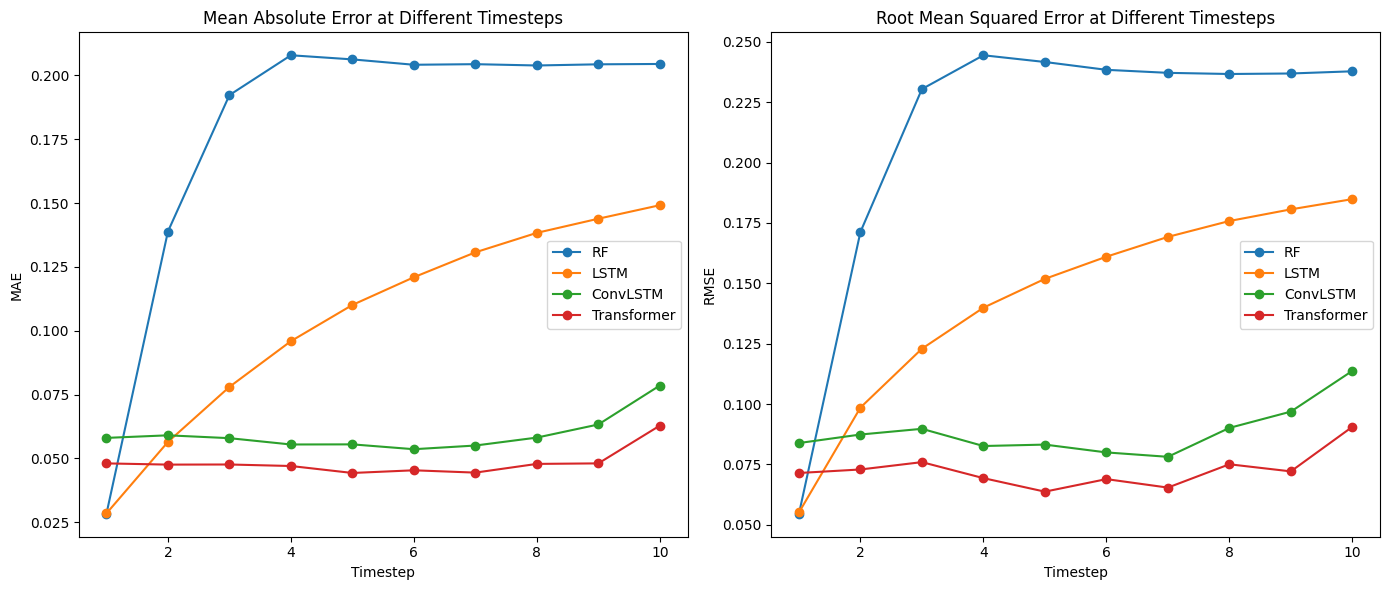

In [ ]:
import matplotlib.pyplot as plt

# Prepare lists to store MAE and RMSE values for all models
mae_values_rf = [0.028334, 0.138880, 0.192296, 0.207905, 0.206285, 0.204184, 0.204415, 0.203902, 0.204359, 0.204496]
mae_values_lstm = [0.028474, 0.056477, 0.078029, 0.095939, 0.110122, 0.120978, 0.130731, 0.138358, 0.143895, 0.149183]
mae_values_convLSTM = [0.058059, 0.059065, 0.057951, 0.055477, 0.055523, 0.053627, 0.055069, 0.058176, 0.063315, 0.078570]
mae_values_transformer = [0.048072, 0.047595, 0.047641, 0.047051, 0.044322, 0.045369, 0.044461, 0.047873, 0.048078, 0.062867]

rmse_values_rf = [0.054547, 0.171270, 0.230454, 0.244461, 0.241672, 0.238430, 0.237179, 0.236701, 0.236911, 0.237818]
rmse_values_lstm = [0.055089, 0.098538, 0.122912, 0.139905, 0.151850, 0.161029, 0.169229, 0.175810, 0.180634, 0.184872]
rmse_values_convLSTM = [0.083851, 0.087380, 0.089743, 0.082619, 0.083208, 0.079968, 0.078146, 0.090116, 0.096864, 0.113739]
rmse_values_transformer = [0.071450, 0.072901, 0.075944, 0.069317, 0.063714, 0.068909, 0.065398, 0.075054, 0.072114, 0.090563]

# Indices for X-axis for the plot
timesteps = list(range(1, 11))

# Create a figure with two subplots - one for MAE and another for RMSE
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the MAE values
for mae_values, label in [
    (mae_values_rf, 'RF'),
    (mae_values_lstm, 'LSTM'),
    (mae_values_convLSTM, 'ConvLSTM'),
    (mae_values_transformer, 'Transformer')
]:
    ax[0].plot(timesteps, mae_values, marker='o', label=label)

ax[0].set_xlabel('Timestep')
ax[0].set_ylabel('MAE')
ax[0].set_title('Mean Absolute Error at Different Timesteps')
ax[0].legend()


# Plotting the RMSE values
for rmse_values, label in [
    (rmse_values_rf, 'RF'),
    (rmse_values_lstm, 'LSTM'),
    (rmse_values_convLSTM, 'ConvLSTM'),
    (rmse_values_transformer, 'Transformer')
]:
    ax[1].plot(timesteps, rmse_values, marker='o', label=label)


ax[1].set_xlabel('Timestep')
ax[1].set_ylabel('RMSE')
ax[1].set_title('Root Mean Squared Error at Different Timesteps')
ax[1].legend()

# Show the plots
plt.tight_layout()
plt.show()
